In [1]:
# importing packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# load data + generate colors
seed = np.random.seed()
df = pd.read_csv('/Users/SnehPandya/Desktop/DeepLearningAGN/data/clean_full_data_absma2g.csv')
df = df.drop(columns = ['Mass_ground_truth','RA', 'DEC', 'ID', 'ERR', 'M_i','M_g','M_r','M_z', 'M_u', 'mu','Unnamed: 0'])
df['ug'] = df.apply(lambda row: row.u_band - row.g_band,axis=1)
df['gr'] = df.apply(lambda row: row.g_band - row.r_band,axis=1)
df['ri'] = df.apply(lambda row: row.r_band - row.i_band,axis=1)
df['iz'] = df.apply(lambda row: row.i_band - row.z_band,axis=1)
df['zu'] = df.apply(lambda row: row.z_band - row.u_band,axis=1)
df.head()

,u_band,g_band,r_band,i_band,z_band,z,ug,gr,ri,iz,zu
0,18.982250,18.900643,18.596375,18.584750,18.720857,1.1875,0.081607,0.304268,0.011625,-0.136107,-0.261393
1,20.822754,20.706984,20.583098,20.400262,20.097541,2.0993,0.115770,0.123885,0.182836,0.302721,-0.725213
2,21.185649,20.891439,20.409386,20.336351,20.082965,1.1103,0.294211,0.482053,0.073035,0.253386,-1.102684
3,20.238111,19.877519,19.916019,19.845519,19.731352,0.6794,0.360593,-0.038500,0.070500,0.114167,-0.506759
4,17.895957,17.664872,17.407213,17.446128,17.437894,1.0459,0.231085,0.257660,-0.038915,0.008234,-0.458064


In [3]:
# define feature and target numpy arrays, do train and test split
X = df.iloc[:, 6:].values
y = df.iloc[:,5].values
X = X.astype(np.float32)
sc = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = seed)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train_t = torch.from_numpy(X_train)
y_train_t = torch.from_numpy(y_train)
X_test_t = torch.from_numpy(X_test)
y_test_t = torch.from_numpy(y_test)

In [4]:
# define train and test dataset, consolidate tensors
train_ds = TensorDataset(X_train_t,y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)

In [5]:
# define train data loader -- does dtype conversion
batch_size = 5
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [6]:
# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.fc1 = nn.Linear(6, 64)
#         self.fc2 = nn.Linear(64, 64)
#         self.fc3 = nn.Linear(64, 64)
#         self.fc4 = nn.Linear(64, 1)

#     def forward(self, x):
#         x = F.relu(self.fc1(x.float()))
#         x = F.relu(self.fc2(x.float()))
#         x = F.relu(self.fc3(x.float()))
#         x = self.fc4(x.float())
#         return x

# net = Net()
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(5, 64)
#         self.fc2 = nn.Linear(64, 64)
#         self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 64)
        self.fc6 = nn.Linear(64, 64)
#         self.fc7 = nn.Linear(128, 64)
#         self.fc8 = nn.Linear(64, 64)
        self.fc9 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x.float()))
#         x = F.relu(self.fc2(x.float()))
#         x = F.relu(self.fc3(x.float()))
        x = F.relu(self.fc4(x.float()))
        x = F.relu(self.fc5(x.float()))
        x = F.relu(self.fc6(x.float()))
#         x = F.relu(self.fc7(x.float()))
#         x = F.relu(self.fc8(x.float()))
        x = self.fc9(x.float())
        return x

net = Net()

In [7]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = F.smooth_l1_loss

In [8]:
# def fit(num_epochs, model, loss_fn, optimizer):
#     for epoch in range(num_epochs): # full passes over the data
#         for data in train_ds:  # `data` is a batch of data
#             X, y = data  # X is the batch of features, y is the batch of targets.
#             net.zero_grad()  # sets gradients to 0 before loss calc. You will do this likely every step.
#             output = net(X.float())  # pass in the reshaped batch (recall they are 28x28 atm)
#             loss = loss_fn(output, y.float()) # calc and grab the loss value
#             loss.backward()  # apply this loss backwards thru the network's parameters
#             optimizer.step()  # attempt to optimize weights to account for loss/gradients
#         print(loss)
def train(num_epochs, model, loss_fn, optimizer):
    outputs_pred = []
    outputs_y = []
    for epoch in range(num_epochs): # full passes over the data
        for data in train_ds:  # `data` is a batch of data
            X, y = data  # X is the batch of features, y is the batch of targets.
            outputs_y.append(y.float())
            net.zero_grad()  # sets gradients to 0 before loss calc. You will do this likely every step.
            output = net(X.float()) # pass in the reshaped batch (recall they are 28x28 atm)
            outputs_pred.append(output.float())
            loss = loss_function(output, y.float())# calc and grab the loss value
            loss.backward()  # apply this loss backwards thru the network's parameters
            optimizer.step()# attempt to optimize weights to account for loss/gradients
        inputs = torch.stack(outputs_y)
        results = torch.cat(outputs_pred).data
        rmse = np.sqrt(metrics.mean_squared_error(inputs, results))
        plt.plot(inputs,inputs,color='black', label = 'Mass Ground Truth')
        plt.scatter(inputs,results,s=2,color='blue', label = 'NN prediction')
        print(loss)
        plt.title('EPOCH:' + str(epoch) +'/'+ str(num_epochs) + ', RMSE:' + str(rmse))
        plt.xlabel('Mass')
        plt.ylabel('Mass')
        plt.legend()
        plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


tensor(0.0591, grad_fn=<SmoothL1LossBackward>)


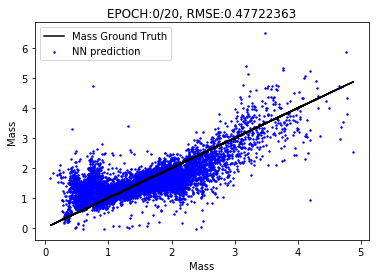

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


tensor(0.0247, grad_fn=<SmoothL1LossBackward>)


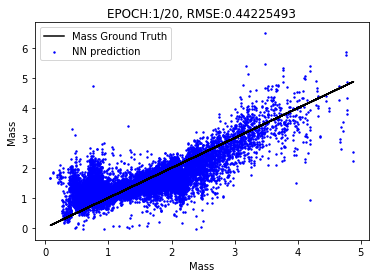

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


tensor(0.0046, grad_fn=<SmoothL1LossBackward>)


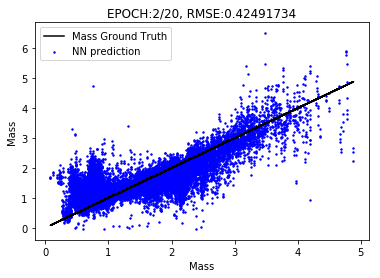

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


tensor(0.0012, grad_fn=<SmoothL1LossBackward>)


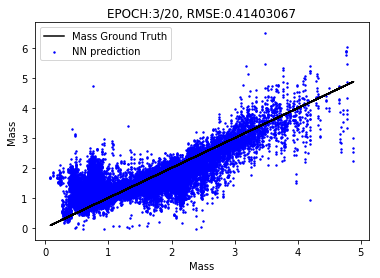

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


tensor(0.0130, grad_fn=<SmoothL1LossBackward>)


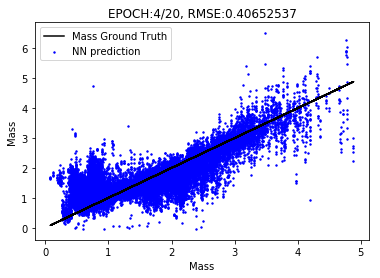

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


tensor(0.0096, grad_fn=<SmoothL1LossBackward>)


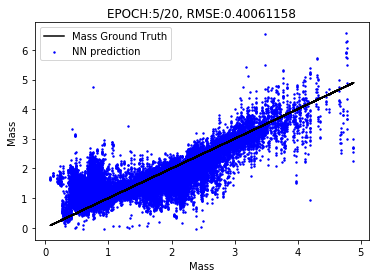

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


tensor(0.0088, grad_fn=<SmoothL1LossBackward>)


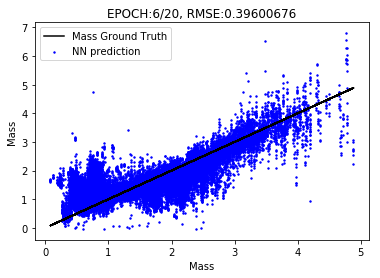

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


tensor(0.0076, grad_fn=<SmoothL1LossBackward>)


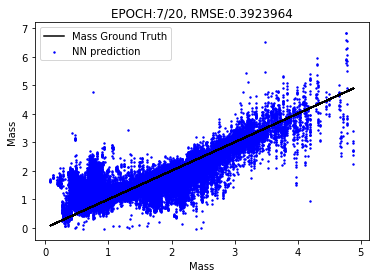

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


tensor(0.0028, grad_fn=<SmoothL1LossBackward>)


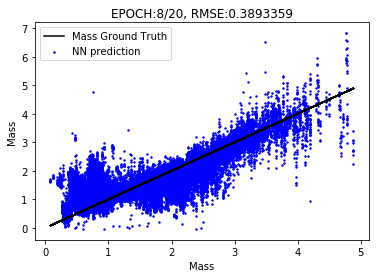

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


tensor(0.0018, grad_fn=<SmoothL1LossBackward>)


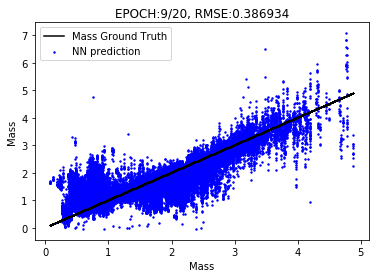

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


tensor(0.0026, grad_fn=<SmoothL1LossBackward>)


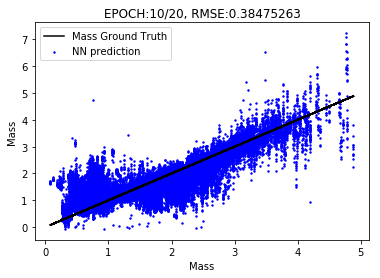

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


tensor(0.0024, grad_fn=<SmoothL1LossBackward>)


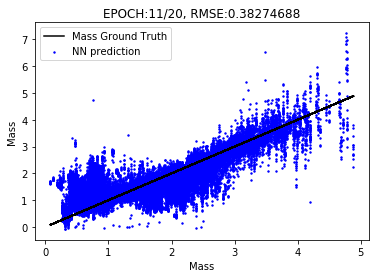

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


tensor(0.0038, grad_fn=<SmoothL1LossBackward>)


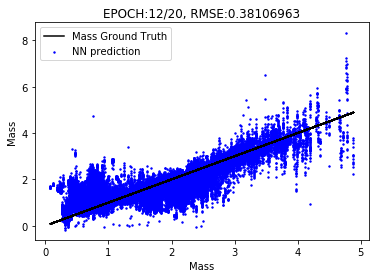

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


tensor(0.0100, grad_fn=<SmoothL1LossBackward>)


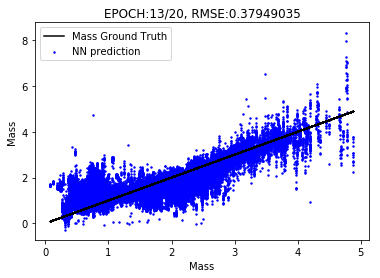

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


tensor(0.0073, grad_fn=<SmoothL1LossBackward>)


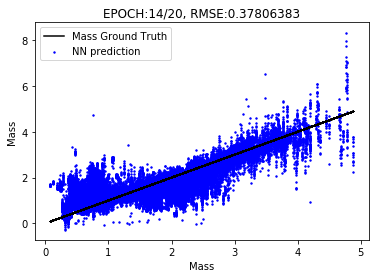

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


tensor(0.0024, grad_fn=<SmoothL1LossBackward>)


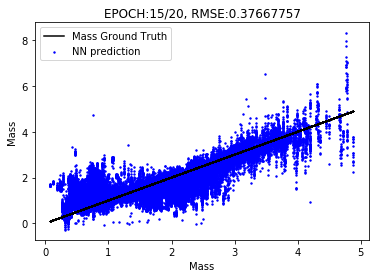

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


tensor(0.0027, grad_fn=<SmoothL1LossBackward>)


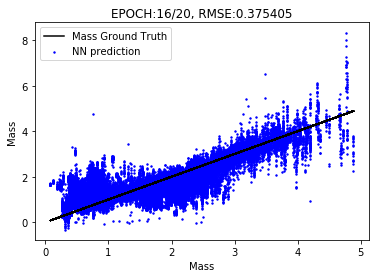

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


tensor(0.0101, grad_fn=<SmoothL1LossBackward>)


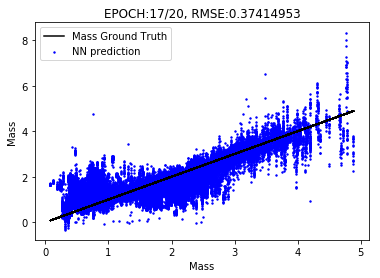

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


tensor(0.0035, grad_fn=<SmoothL1LossBackward>)


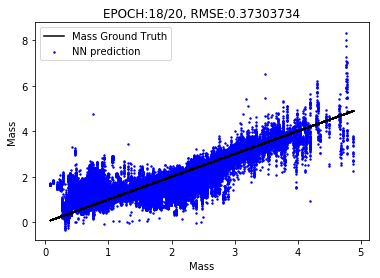

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


tensor(0.0007, grad_fn=<SmoothL1LossBackward>)


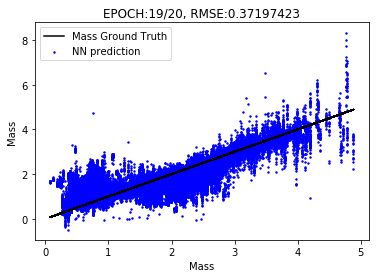

In [9]:
train(20, net, loss_function, optimizer)

In [10]:
print(test_ds[:][1].numpy())
print(test_ds[:][0].numpy())

[0.174  0.68   1.6302 ... 1.4437 1.3988 1.2469]
[[-0.8761191  -1.0241373   1.491525   -1.9717146   1.0033364 ]
 [-0.25369456 -1.0657742  -0.86032504 -0.3191791   0.7259055 ]
 [-0.48925722 -0.4146533   0.8530664  -0.7896524   0.45656598]
 ...
 [-0.25872248  0.733845    0.64658284 -0.15835875 -0.12331952]
 [-0.86443806  0.33399767 -0.2234317  -1.0203537   0.7616073 ]
 [-0.4303522   0.53194153 -1.2010064  -0.65291774  0.50658596]]


In [11]:
preds = net(test_ds[:][0].float())

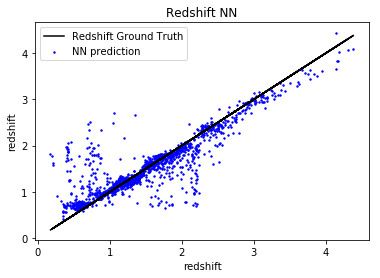

In [12]:
plt.plot(test_ds[:][1],test_ds[:][1],color='black', label = 'Redshift Ground Truth')
plt.scatter(test_ds[:][1],preds.detach().numpy(),s=2,color='blue', label = 'NN prediction')
plt.xlabel('redshift')
plt.ylabel('redshift')
plt.legend()
plt.title ('Redshift NN')

In [13]:
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_t, preds.detach().numpy())))
print('r2 score:', metrics.r2_score(y_test_t, preds.detach().numpy()))

Root Mean Squared Error: 0.3586765806585717
r2 score: 0.7529573982482803


In [14]:
#.398